In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import time
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule


MODEL_PARAMS = {
"patch_size":16,  # 8, 16, 32, 64, 128
"num_samples": 100,
"target_dim": 1,
"feat_dynamic_real_dim": 0,
"past_feat_dynamic_real_dim": 0,
}

In [2]:
sys.path.insert(1, os.path.join(os.path.dirname(os.getcwd()), "scripts") )

from model_utils import generate_model_input, preprocess_data, get_predictions, plot_results, mean_absolute_percentage_error

root_path = os.path.dirname(os.getcwd())

# forecast with Moirai

total length: 4581
Index(['target'], dtype='object')
time frequency: 1 days 00:00:00
2009-01-03 00:00:00 2021-07-19 00:00:00


<Axes: xlabel='date'>

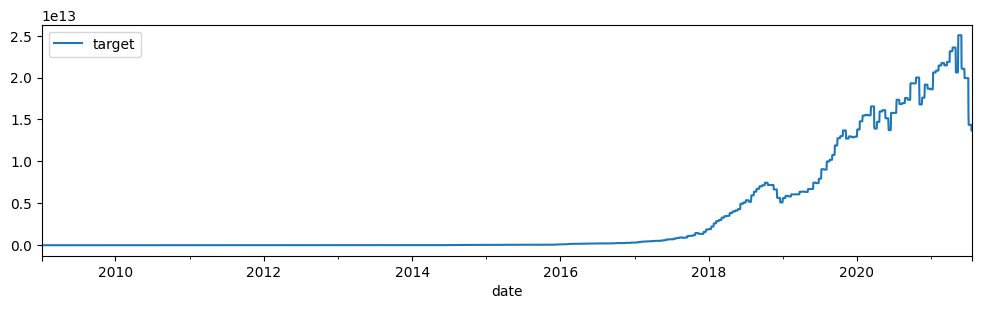

In [3]:
# First: Load dataframe and clean it
df = pd.read_csv(os.path.join(root_path, "data", "dataset1.csv"), parse_dates=True)
date_colname= "date"
target_colname = "target"


df[date_colname] = pd.to_datetime(df[date_colname])
df.set_index(date_colname, inplace=True)  # Normalize the target variable

print(f"total length: {df.shape[0]}")
print(df.columns)
print(f"time frequency: {df.index.diff()[1]}")
print(df.index[0], df.index[-1])
df.plot(figsize=(12, 3))

torch.Size([1, 4380, 1])
torch.Size([1, 4380, 1])
torch.Size([1, 4380])


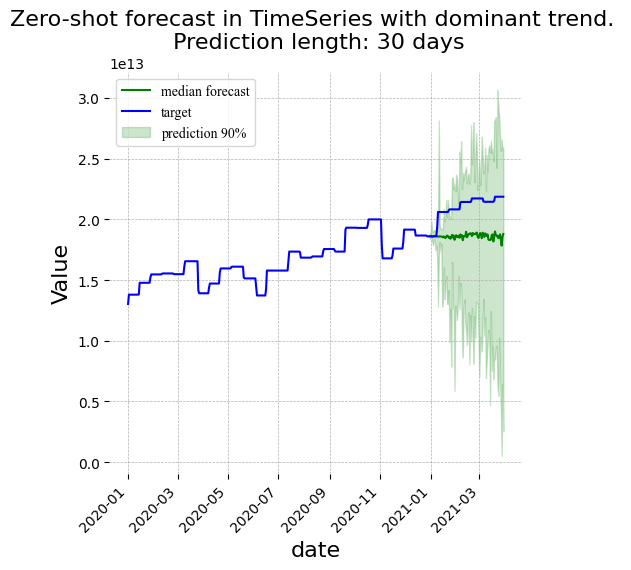

In [4]:
# create the train and test sets
train_window = 12 * 365 # days
prediction_window = 90  # days

train = df.iloc[:train_window, :].copy()
test = df.iloc[train_window:, :].copy()

# preprocess the data
target_tensor, is_target_observed, is_target_padded= preprocess_data(target=train[target_colname].values)

print(target_tensor.shape)
print(is_target_observed.shape)
print(is_target_padded.shape)

# Define the model
model = MoiraiMoEForecast(
    module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
    prediction_length= prediction_window,
    context_length=train_window,
    **MODEL_PARAMS,
)

# Make the forecast
forecast = model(
    past_target=target_tensor,
    past_observed_target=is_target_observed,
    past_is_pad=is_target_padded,
)

# Collect the median forecast and CI into a DataFrame
predictions_df = get_predictions(
    forecast_tensor=forecast[0],
    train_set=train,
    date_colname=date_colname
)

# Merge predictions with original data
true_and_preds = pd.merge(test, predictions_df, left_index=True, right_index=True, how="right")
all_data = pd.concat([train.iloc[-365:, :], true_and_preds])

# # Plot the results
figure = plot_results(
    results_df=all_data,
    target_colname=target_colname,
    title="Zero-shot forecast in TimeSeries with dominant trend. \n Prediction length: 30 days",
    figsize=(5, 6)
)
plt.show()

In [5]:
# Compute the forecast error
true_and_preds.dropna(inplace=True)
mape = mean_absolute_percentage_error(
    y_true=true_and_preds[target_colname].values,
    y_pred=true_and_preds["median_forecast"].values
)

print(mape)

11.254305968817999


## Patch size experiment

In [6]:
patches_list = [8, 16, 32, 64, 128]
train_window1 = 12 * 365 # days
prediction_window1 = 90
mape_list = []
time_list = []

train1 = df.iloc[:train_window1, :].copy()
test1 = df.iloc[train_window1:, :].copy()

for patch in patches_list:
    start_time = time.time()
    # preprocess the data
    target_tensor, is_target_observed, is_target_padded= preprocess_data(target=train1[target_colname].values)

    MODEL_PARAMS["patch_size"] = patch
    # Define the model
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
        prediction_length= prediction_window1,
        context_length=train_window1,
        **MODEL_PARAMS,
    )

    # Make the forecast
    forecast = model(
        past_target=target_tensor,
        past_observed_target=is_target_observed,
        past_is_pad=is_target_padded,
    )

    # Collect the median forecast and CI into a DataFrame
    predictions_df = get_predictions(
        forecast_tensor=forecast[0],
        train_set=train1,
        date_colname=date_colname
    )

    # Merge predictions with original data
    true_and_preds = pd.merge(test1, predictions_df, left_index=True, right_index=True, how="right")
    all_data = pd.concat([train1.iloc[-200:, :], true_and_preds])

    true_and_preds.dropna(inplace=True)
    mape = mean_absolute_percentage_error(
        y_true=true_and_preds[target_colname].values,
        y_pred=true_and_preds["median_forecast"].values
    )
    end_time = time.time()
    elapsed_time = end_time - start_time
    mape_list.append(mape)
    time_list.append(elapsed_time)

mape_batch_size_df = pd.DataFrame(
    {"patch_size": patches_list, "mape": mape_list, "elapsed_time": time_list}
)
mape_batch_size_df

,patch_size,mape,elapsed_time
0,8,86.009756,89.466492
1,16,11.445497,12.023440
2,32,85.870800,2.889319
3,64,85.673976,1.115083
4,128,86.454470,0.619894


## Rolling forecast using predictions

total length: 4581
Index(['target'], dtype='object')
time frequency: 1 days 00:00:00
2009-01-03 00:00:00 2021-07-19 00:00:00


<Axes: xlabel='date'>

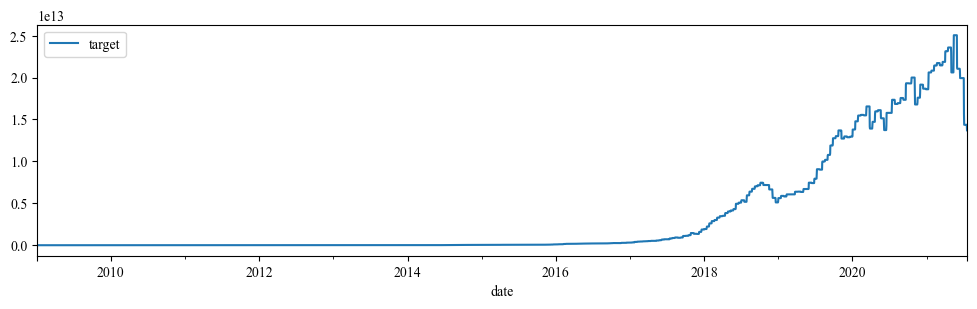

In [7]:
# First: Load dataframe

df = pd.read_csv(os.path.join(root_path, "data", "dataset1.csv"), parse_dates=True)
date_colname= "date"
target_colname = "target"

df[date_colname] = pd.to_datetime(df[date_colname])
df.set_index(date_colname, inplace=True)

print(f"total length: {df.shape[0]}")
print(df.columns)

print(f"time frequency: {df.index.diff()[1]}")
print(df.index[0], df.index[-1])
df.plot(figsize=(12, 3))


In [8]:
# create the train and test sets
train_window =   12 * 365  # days
prediction_window = 30  # days
niter = 3  # iterations for the rolling forecast
MODEL_PARAMS["patch_size"] = 16

train = df.iloc[:train_window, :].copy()
test = df.iloc[train_window:, :].copy()

frequency = train.index.diff()[1]
train_original = train.copy()  # to be used for plotting

# Rolling forecast
all_predictions = []
for i in range(niter):
    print(f"interation: {i}")
    if i == 0:
        # Use the original train
       train = generate_model_input(train_df=train, date_colname=date_colname, target_colname=target_colname, median_forecast=None)

    elif last_date_train + frequency * prediction_window in test.index:
        # In case you receive new input data (here represented by the test)
        train = generate_model_input(
           train_df=train,
           date_colname=date_colname,
           target_colname=target_colname,
           median_forecast=test.loc[last_date_train + frequency: last_date_train + frequency * prediction_window, target_colname].values
       )

    else:
        # Use forecast to create another forecast
       train = generate_model_input(
           train_df=train,
           date_colname=date_colname,
           target_colname=target_colname,
           median_forecast=predictions_df["median_forecast"].values
       )

    # Preprocess the new train set
    target_tensor, is_target_observed, is_target_padded = preprocess_data(
        target=train[target_colname].values
    )

    # Prepare model
    model = MoiraiMoEForecast(
    module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
    prediction_length=prediction_window,
    context_length=train_window+i*prediction_window,  # Train context is not rolling, it always stars from the beginning
    **MODEL_PARAMS,
    )

    forecast = model(
        past_target=target_tensor,
        past_observed_target=is_target_observed,
        past_is_pad=is_target_padded,
    )

    predictions_df= get_predictions(
        forecast_tensor=forecast[0],
        train_set=train,
        date_colname=date_colname
    )
    last_date_train = predictions_df.index[-1]

    all_predictions.append(predictions_df)

all_predictions_df = pd.concat(all_predictions)


interation: 0
interation: 1
interation: 2


3.577301023640733


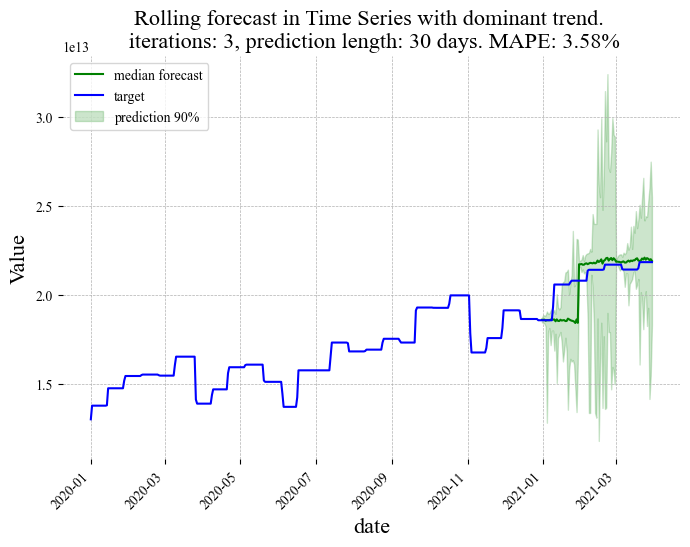

In [9]:
true_and_preds = pd.merge(test, all_predictions_df, left_index=True, right_index=True, how="right")
all_data = pd.concat([train_original.iloc[train_window-365:, :], true_and_preds])

# Get the forecast error
mape_rolling = mean_absolute_percentage_error(
        y_true=true_and_preds[target_colname].values,
        y_pred=true_and_preds["median_forecast"].values
    )

print(mape_rolling)

figure = plot_results(
    results_df=all_data,
    target_colname=target_colname,
    title=f"Rolling forecast in Time Series with dominant trend. \n iterations: {niter}, prediction length: {prediction_window} days. MAPE: {mape_rolling:.2f}%",
)
plt.show()